In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle, os, sys
import matplotlib as mpl
from scipy.interpolate import SmoothBivariateSpline
from matplotlib.colors import LogNorm, Normalize

In [2]:
from get_weight_isoscalar_constant_Emin_50GeV_Q2min1GeV import *

In [3]:
# from get_weight_isoscalar_constant_Emin_50GeV import *
pth_spl = '../diff_xsec/splines_Nov14/'
wf_nucc = pickle.load(open(pth_spl+'NuMu_CC_','rb'), encoding='latin1') 
wf_nubarcc = pickle.load(open(pth_spl+'NuMu_Bar_CC_','rb'), encoding='latin1') 
wf_nunc = pickle.load(open(pth_spl+'NuMu_NC_','rb'), encoding='latin1') 
wf_nubarnc = pickle.load(open(pth_spl+'NuMu_Bar_NC_','rb'), encoding='latin1') 

#coef = 0. -- Genie -> Genie
#coef = 1. -- Genie -> Nugen
def get_weight(E, y, xs_type, coef=1., lgE_min=2.): 
    
    lgE = np.log10(E)
    
    spl_lgE_reg = np.transpose(np.argwhere(lgE > lgE_min))[0]
    ext_lgE_reg = np.transpose(np.argwhere(lgE <= lgE_min))[0]
    
    w0 = np.ones(len(lgE))
    
    if xs_type == 'NuCC':
        weight_func = wf_nucc
    elif xs_type == 'NuBarCC':
        weight_func = wf_nubarcc
    elif xs_type == 'NuNC':
        weight_func = wf_nunc
    elif xs_type == 'NuBarNC':
        weight_func = wf_nubarnc
    else:
        print ('specify xs_type correctly!')
    
    w0[spl_lgE_reg] = weight_func.ev(lgE[spl_lgE_reg],y[spl_lgE_reg])
    w0[ext_lgE_reg] = weight_func.ev(w0[ext_lgE_reg]*lgE_min,y[ext_lgE_reg])
    w = w0*(1. + (1./w0 - 1)*(1. - coef))
    
    return w0

In [4]:
indir = '/home/mliubar/projects/rpp-kenclark/hignight/atmo_flux'
numu = pickle.load(open(os.path.join(indir, 'Level5p_IC86.2013_genie_numu.14600.rlogL.pckl'),'rb'),encoding='latin1')
nue = pickle.load(open(os.path.join(indir, 'Level5p_IC86.2013_genie_nue.12600.rlogL.pckl'),'rb'),encoding='latin1')

In [5]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['lines.linewidth'] = 2.0

In [6]:
asp_r = 1./12.*6.

left, width = 0.23, 0.85
bottom, height = 0.16, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom-0.2, width, height]
rect2 = [left*asp_r, bottom, height, 0.2]

# xsec type separation

In [7]:
nu = {}
for k in numu.keys():
    if k == 'weight_e': continue
    if k == 'weight_mu': 
        nu['weight_emu'] = np.concatenate((nue['weight_e'],numu['weight_mu']))
        continue
    nu[k] = np.concatenate((nue[k],numu[k]))

In [8]:
def myargwh(cond):
    return np.transpose(np.argwhere(cond))[0]

In [9]:
# dis = (np.abs(numu['ma_res']).sum(axis=1) == 0)*(np.abs(numu['ma_qe']).sum(axis=1) == 0)
ind0 = myargwh(np.abs(nu['ma_res']).sum(axis=1) == 0)
ind1 = myargwh(np.abs(nu['ma_qe'][ind0]).sum(axis=1) == 0)
# indQ2 = myargwh(nu['GENIE_Q2s'][ind0[ind1]] > 0.8)
dis = ind0[ind1]#[indQ2]]

In [10]:
CCdis = dis[myargwh(nu['interaction'][dis]==1.)]
NCdis = dis[myargwh(nu['interaction'][dis]==2.)]
CCnotdis = ~dis[myargwh(nu['interaction'][~dis]==1.)]
NCnotdis = ~dis[myargwh(nu['interaction'][~dis]==2.)]

In [11]:
CCdisNu = CCdis[myargwh(nu['ptype'][CCdis]>0)]
NCdisNu = NCdis[myargwh(nu['ptype'][NCdis]>0)]
CCnotdisNu = CCnotdis[myargwh(nu['ptype'][CCnotdis]>0)]
NCnotdisNu = NCnotdis[myargwh(nu['ptype'][NCnotdis]>0)]

CCdisNuBar = CCdis[myargwh(nu['ptype'][CCdis]<0)]
NCdisNuBar = NCdis[myargwh(nu['ptype'][NCdis]<0)]
CCnotdisNuBar = CCnotdis[myargwh(nu['ptype'][CCnotdis]<0)]
NCnotdisNuBar = NCnotdis[myargwh(nu['ptype'][NCnotdis]<0)]

In [12]:
val = np.log10(nu['energy'])
glob_w = nu['weight_emu']

In [13]:
# total + differential
def get_w(weight=glob_w, nyears=1, 
          corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
    if nyears == 0:
        m = 1.
    else:
        m = m = 365*24*60.*60.*nyears
        
    total_xsec_extr = 'constant'
    total_xsec_lgE_min = 2.
        
    wf = np.ones(len(glob_w))
    if corr['CCnu']:
        wf[CCdisNu] = wf[CCdisNu]*get_weight(nu['energy'][CCdisNu], 
                                             nu['GENIE_y'][CCdisNu], 
                                             xs_type='NuCC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][CCdisNu], 
                        nu='Nu', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['CCnubar']:
        wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight(nu['energy'][CCdisNuBar], 
                                             nu['GENIE_y'][CCdisNuBar], 
                                             xs_type='NuBarCC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][CCdisNuBar], 
                        nu='NuBar', current='CC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnu']:
        wf[NCdisNu] = wf[NCdisNu]*get_weight(nu['energy'][NCdisNu], 
                                             nu['GENIE_y'][NCdisNu], 
                                             xs_type='NuNC', 
                                             coef=1.)\
        *get_weight_iso(nu['energy'][NCdisNu], 
                        nu='Nu', current='NC', 
                        ext_type=total_xsec_extr,
                        lgE_min_cust=total_xsec_lgE_min)
    if corr['NCnubar']:
        wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight(nu['energy'][NCdisNuBar], 
                                             nu['GENIE_y'][NCdisNuBar], 
                                             xs_type='NuBarNC', 
                                             coef=1.)\
       *get_weight_iso(nu['energy'][NCdisNuBar], 
                       nu='NuBar', current='NC', 
                       ext_type=total_xsec_extr,
                       lgE_min_cust=total_xsec_lgE_min)

    wr = weight*m*wf
    return wr, m

In [201]:
# # differential
# def get_w(weight=glob_w, nyears=1, 
#           corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
#     if nyears == 0:
#         m = 1.
#     else:
#         m = m = 365*24*60.*60.*nyears
        
#     total_xsec_extr = 'constant'
#     total_xsec_lgE_min = 2.
        
#     wf = np.ones(len(glob_w))
#     if corr['CCnu']:
#         wf[CCdisNu] = wf[CCdisNu]*get_weight(nu['energy'][CCdisNu], 
#                                              nu['GENIE_y'][CCdisNu], 
#                                              xs_type='NuCC', 
#                                              coef=1.)
#     if corr['CCnubar']:
#         wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight(nu['energy'][CCdisNuBar], 
#                                              nu['GENIE_y'][CCdisNuBar], 
#                                              xs_type='NuBarCC', 
#                                              coef=1.)
#     if corr['NCnu']:
#         wf[NCdisNu] = wf[NCdisNu]*get_weight(nu['energy'][NCdisNu], 
#                                              nu['GENIE_y'][NCdisNu], 
#                                              xs_type='NuNC', 
#                                              coef=1.)
#     if corr['NCnubar']:
#         wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight(nu['energy'][NCdisNuBar], 
#                                              nu['GENIE_y'][NCdisNuBar], 
#                                              xs_type='NuBarNC', 
#                                              coef=1.)

#     wr = weight*m*wf
#     return wr, m

In [198]:
# # total
# def get_w(weight=glob_w, nyears=1, 
#           corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}):
    
#     if nyears == 0:
#         m = 1.
#     else:
#         m = m = 365*24*60.*60.*nyears
        
#     total_xsec_extr = 'constant'
#     total_xsec_lgE_min = 2.
        
#     wf = np.ones(len(glob_w))
#     if corr['CCnu']:
#         wf[CCdisNu] = wf[CCdisNu]*get_weight_iso(nu['energy'][CCdisNu], 
#                         nu='Nu', current='CC', 
#                         ext_type=total_xsec_extr,
#                         lgE_min_cust=total_xsec_lgE_min)
#     if corr['CCnubar']:
#         wf[CCdisNuBar] = wf[CCdisNuBar]*get_weight_iso(nu['energy'][CCdisNuBar], 
#                         nu='NuBar', current='CC', 
#                         ext_type=total_xsec_extr,
#                         lgE_min_cust=total_xsec_lgE_min)
#     if corr['NCnu']:
#         wf[NCdisNu] = wf[NCdisNu]*get_weight_iso(nu['energy'][NCdisNu], 
#                         nu='Nu', current='NC', 
#                         ext_type=total_xsec_extr,
#                         lgE_min_cust=total_xsec_lgE_min)
#     if corr['NCnubar']:
#         wf[NCdisNuBar] = wf[NCdisNuBar]*get_weight_iso(nu['energy'][NCdisNuBar], 
#                        nu='NuBar', current='NC', 
#                        ext_type=total_xsec_extr,
#                        lgE_min_cust=total_xsec_lgE_min)

#     wr = weight*m*wf
#     return wr, m

# plots

In [27]:
save_pth = '/home/mliubar/scratch/total_and_diff_xsec_testing_plots_Nov21/'

In [22]:
lgE_r = [0., 3.]
nb = 20

In [23]:
asp_r = 1./12.*6.

left, width = 0.33, 0.8
bottom, height = 0.12, 0.7
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.3, width, height-0.2]
rect2 = [left*asp_r, bottom, width, 0.28]

# NuCC and NuBarCC test

In [176]:
def plot_reco_en_ind(iloc=np.arange(len(nu['reco_energy'])),
                plot_val = np.log10(nu['reco_energy']),
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)
    
    

    ax.set_xlim(0.,3.1)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)
    
    h0, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=w0[iloc])
    
    hc, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=wcorr_c[iloc])

    ########
    
#     n = np.sum(hc)/np.sum(h0)
# #     wcorr_c[iloc] = wcorr_c[iloc]/n
    
#     h0, be = np.histogram(plot_val[iloc], nb, lgE_r, 
#                             weights=w0[iloc])
#     hc, be = np.histogram(plot_val[iloc], nb, lgE_r, 
#                             weights=wcorr_c[iloc])
    
    ########
    
#     print (np.sum(h0))
#     hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    bc = be[:-1] + (be[1]-be[0])/2.

    plt.grid(alpha=0.2)
    ax.axvline(1.68, c='k')
    plt.legend(fontsize=15)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,3.1)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{{(N_{corr} / N_0)}}$')
    ax2.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')

    # sigma0, _ = np.histogram(val, nb, lgE_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    plt.grid(alpha=0.2)
    ax2.axvline(1.68, c='k')
    
    save_name = title.replace(' ', '_') + '_reco_E'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


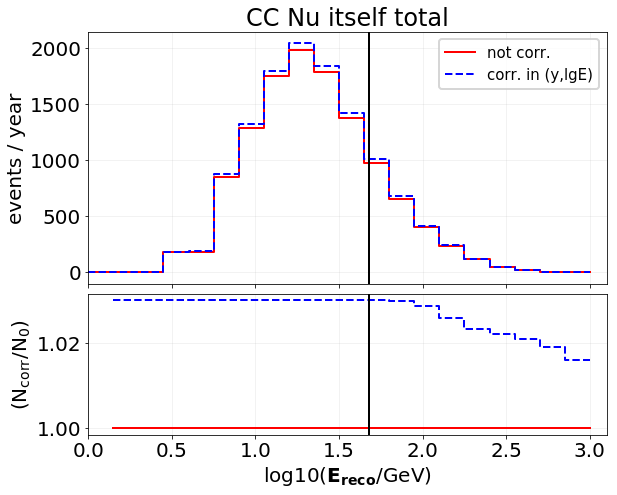

0

In [200]:
plot_reco_en_ind(iloc=CCdisNu,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC Nu itself total')

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


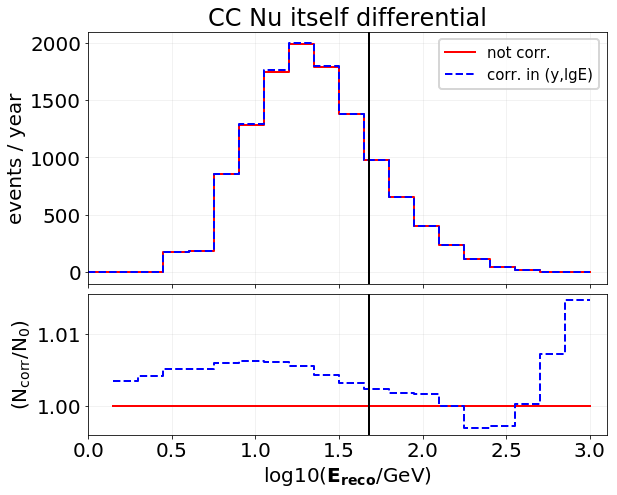

0

In [202]:
plot_reco_en_ind(iloc=CCdisNu,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC Nu itself differential')

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


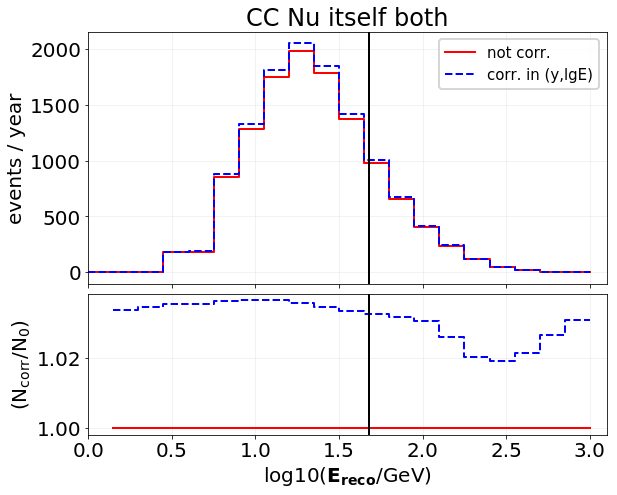

0

In [195]:
plot_reco_en_ind(iloc=CCdisNu,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC Nu itself both')

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


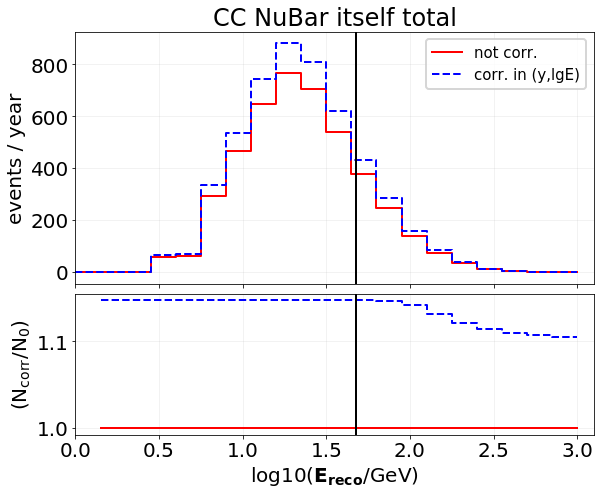

0

In [199]:
plot_reco_en_ind(iloc=CCdisNuBar,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC NuBar itself total')

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


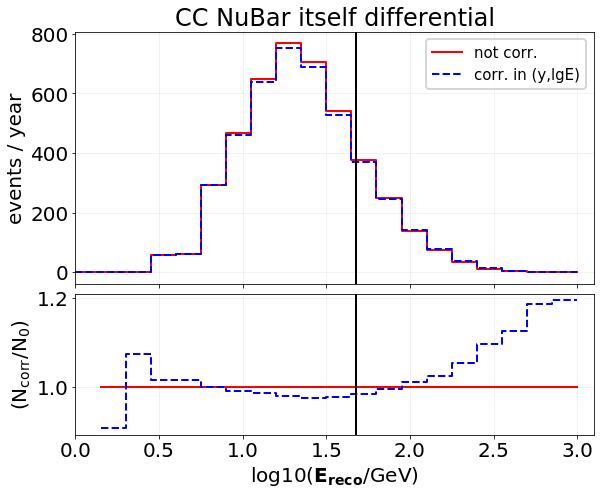

0

In [203]:
plot_reco_en_ind(iloc=CCdisNuBar,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC NuBar itself differential')

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


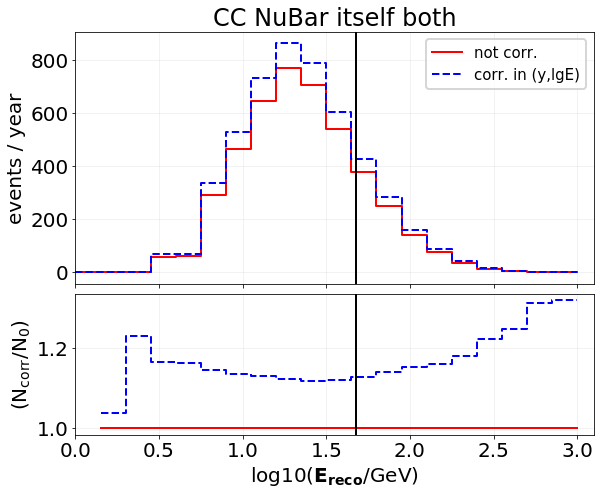

0

In [197]:
plot_reco_en_ind(iloc=CCdisNuBar,
    corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='CC NuBar itself both')

# 2d tests

In [159]:
def plot_y_vs_true_en(#n_ini=ndis,
                      ind_all=dis,
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    
    ind=ind_all
#     nb = 20
    w0, m  = get_w(nyears=1.)
#     wcorr_c = np.ones(len(nu['energy']))
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('initial')
    ax.set_ylabel('y')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')


    
    h0, x, y, _ = plt.hist2d(np.log10(nu['energy'][ind]), nu['GENIE_ys'][ind],
           nb, range=[[0.,3.],[0., 1.]], 
           weights=w0[ind], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
#     plt.legend(fontsize=15)

    plt.show()
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title(title)
    ax.set_ylabel('y')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')

    hc, _, _, _ = plt.hist2d(np.log10(nu['energy'][ind]), nu['GENIE_ys'][ind],
           nb, range=[[0.,3.],[0., 1.]], 
           weights=wcorr_c[ind], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()
    
    
    ######################################
    
    n = np.sum(hc)/np.sum(h0)
    wcorr_c[ind] = wcorr_c[ind]/n
    
    ######################################
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('initial')
    ax.set_ylabel('y')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')


    
    h0, x, y, _ = plt.hist2d(np.log10(nu['energy'][ind_all]), nu['GENIE_ys'][ind_all],
           nb, range=[[0.,3.],[0., 1.]], 
           weights=w0[ind_all], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
#     plt.legend(fontsize=15)

    plt.show()
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title(title)
    ax.set_ylabel('y')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')

    hc, _, _, _ = plt.hist2d(np.log10(nu['energy'][ind_all]), nu['GENIE_ys'][ind_all],
           nb, range=[[0.,3.],[0., 1.]], 
           weights=wcorr_c[ind_all], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()

    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('corrected / initial')
    ax.set_ylabel('y')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')
    
    n = np.sum(hc)/np.sum(h0)
    hc = hc/n
    h_rat = hc/h0
    x0, y0 = np.meshgrid(x, y)
    
    p = plt.pcolor(x0, y0, np.flipud(np.rot90(h_rat)),
           norm=Normalize(vmin=0.5, vmax=1.5),
           cmap='coolwarm'
         )
    
#     ax.set_ylim(0.5,1.5)
    fig.colorbar(p)
    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()
    
    return 0

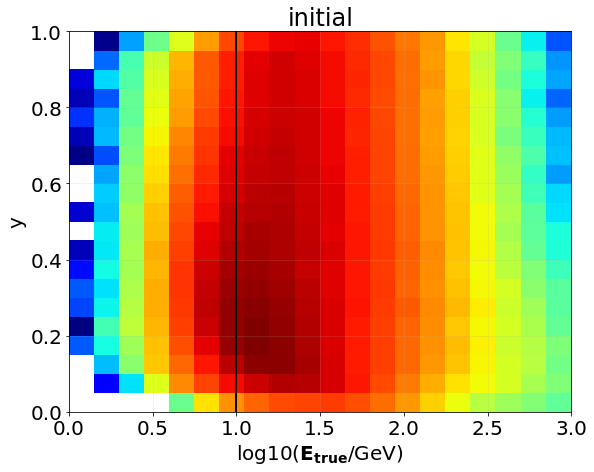

No handles with labels found to put in legend.


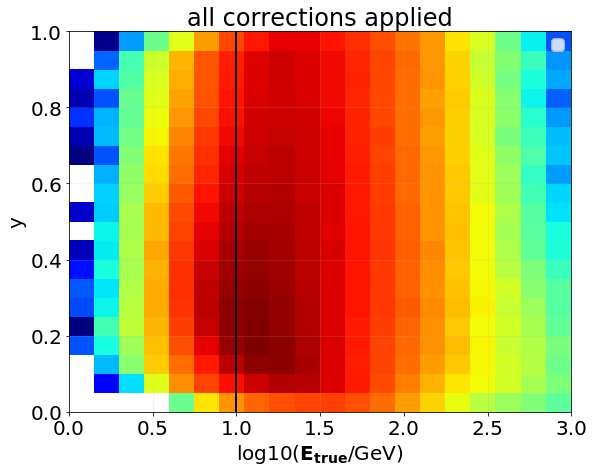

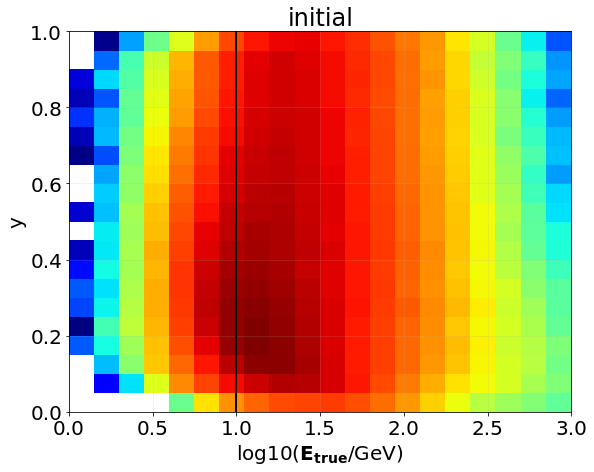

No handles with labels found to put in legend.


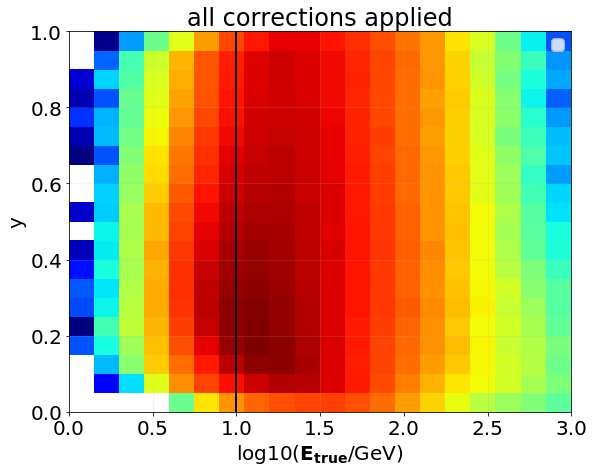

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


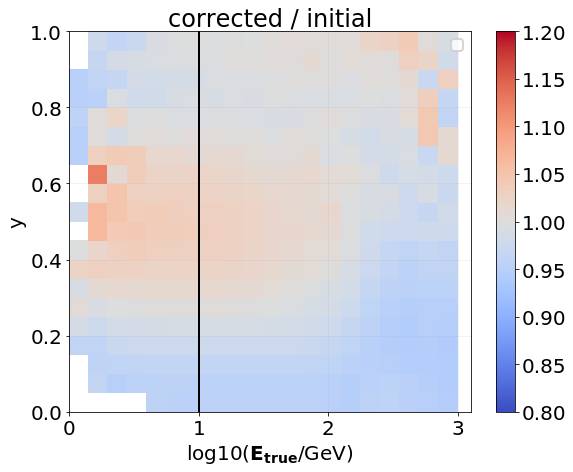

In [155]:
ndis = plot_y_vs_true_en(corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='all corrections applied')

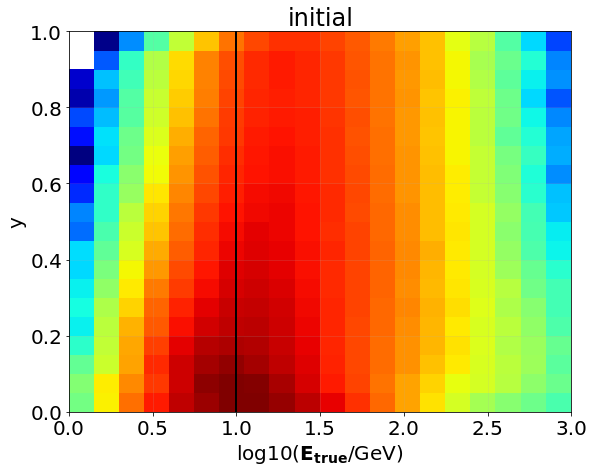

No handles with labels found to put in legend.


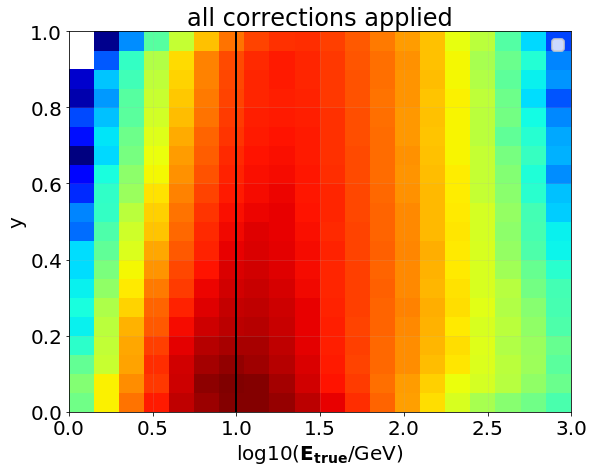

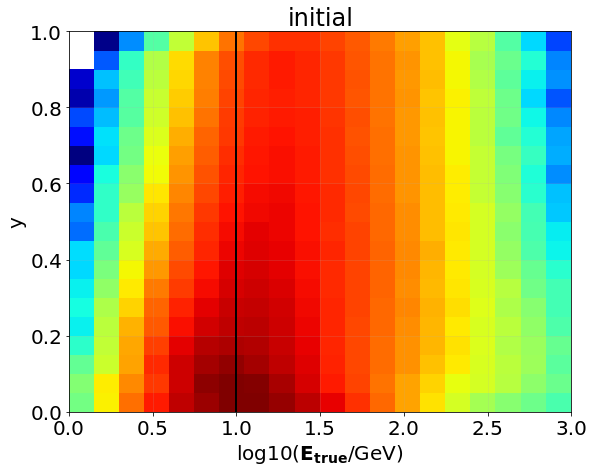

No handles with labels found to put in legend.


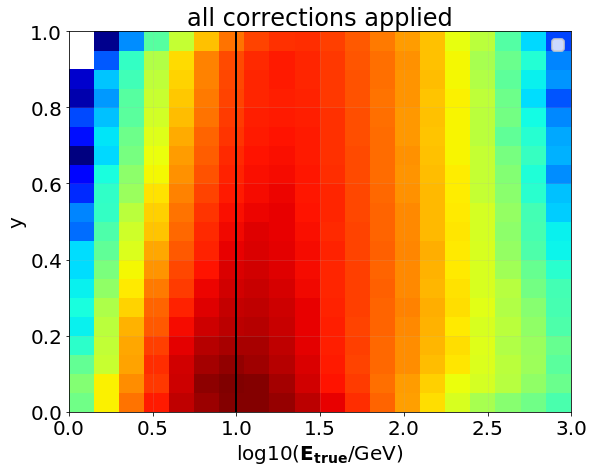

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


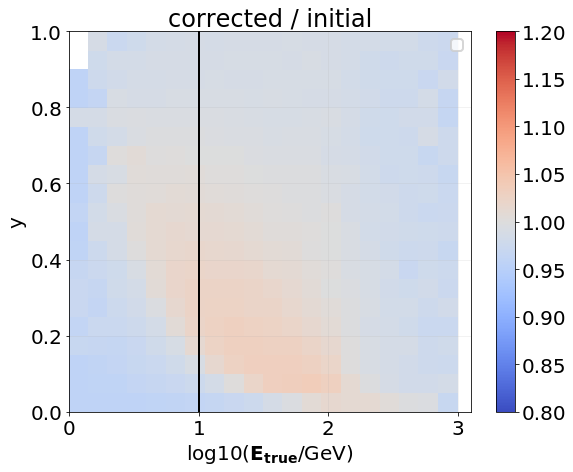

0

In [68]:
plot_y_vs_true_en(#ind=dis,
                  ind_all=np.arange(len(nu['energy'])),
                  corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                  title='all corrections applied')

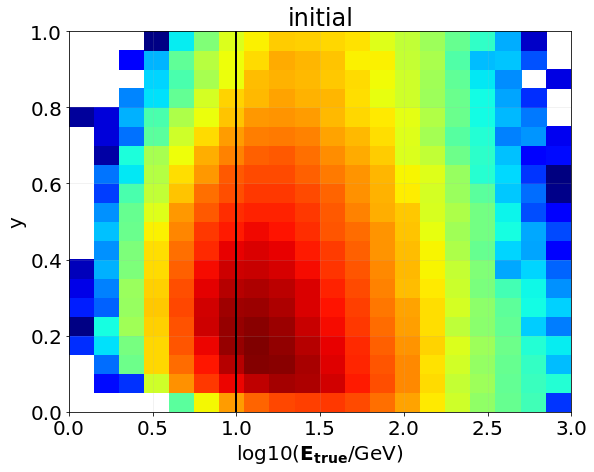

No handles with labels found to put in legend.


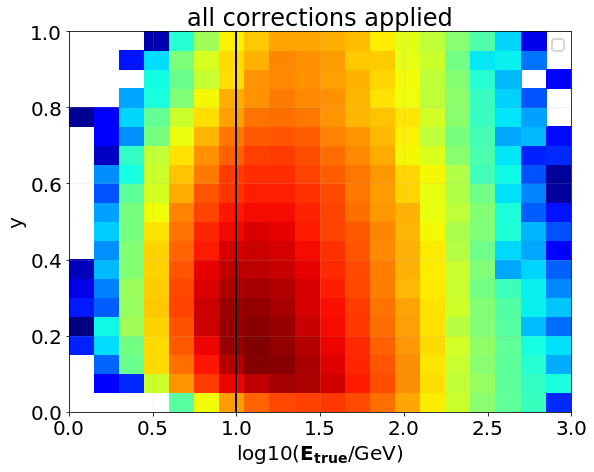

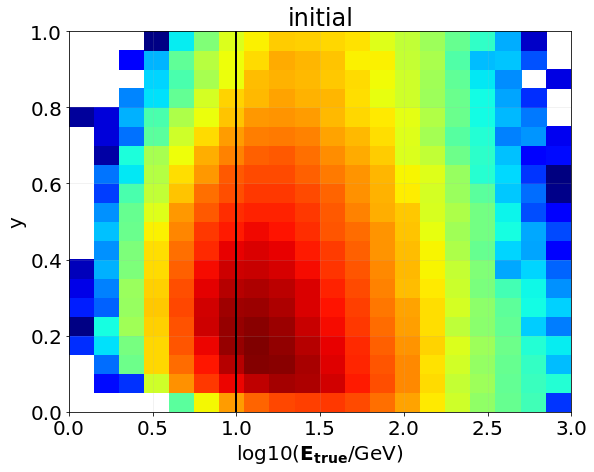

No handles with labels found to put in legend.


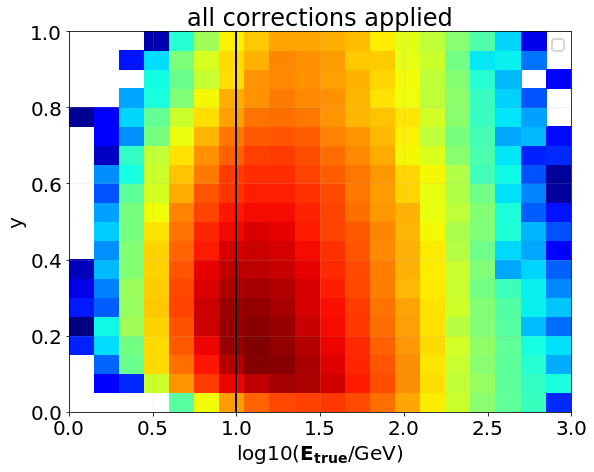

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


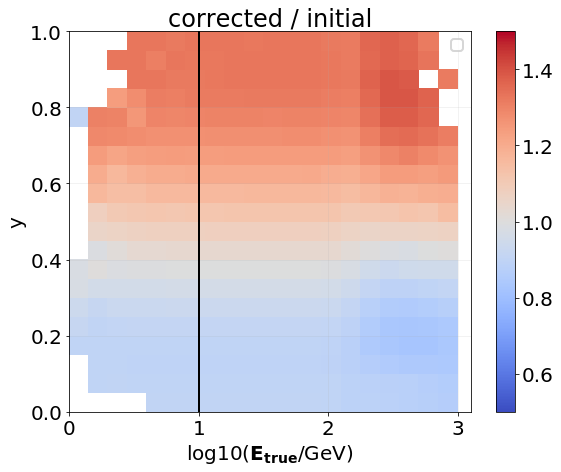

0

In [160]:
plot_y_vs_true_en(#ind=dis,
                  ind_all=CCdisNuBar,
                  corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                  title='all corrections applied')

In [150]:
def plot_y_vs_reco_en(#n_ini=ndis,
                      ind_all=dis,
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    
    ind=ind_all
#     nb = 20
    w0, m  = get_w(nyears=1.)
#     wcorr_c = np.ones(len(nu['reco_energy']))
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('initial')
    ax.set_ylabel('d llh')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')


    
    h0, x, y, _ = plt.hist2d(np.log10(nu['reco_energy'][ind]), nu['delta_llh'][ind],
           nb, range=[[0.,3.],[-3.,np.max(nu['delta_llh'][ind])]], 
           weights=w0[ind], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
#     plt.legend(fontsize=15)

    plt.show()
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title(title)
    ax.set_ylabel('d llh')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')

    hc, _, _, _ = plt.hist2d(np.log10(nu['reco_energy'][ind]), nu['delta_llh'][ind],
           nb, range=[[0.,3.],[-3.,np.max(nu['delta_llh'][ind])]], 
           weights=wcorr_c[ind], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()
    
    
    ######################################
    
    n = np.sum(hc)/np.sum(h0)
    wcorr_c[ind] = wcorr_c[ind]/n
    
    ######################################
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('initial')
    ax.set_ylabel('d llh')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')


    
    h0, x, y, _ = plt.hist2d(np.log10(nu['reco_energy'][ind_all]), nu['delta_llh'][ind_all],
           nb, range=[[0.,3.],[-3., 10.]], 
           weights=w0[ind_all], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
#     plt.legend(fontsize=15)

    plt.show()
    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title(title)
    ax.set_ylabel('d llh')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')

    hc, _, _, _ = plt.hist2d(np.log10(nu['reco_energy'][ind_all]), nu['delta_llh'][ind_all],
           nb, range=[[0.,3.],[-3., 10.]], 
           weights=wcorr_c[ind_all], norm=LogNorm(),
           cmap='jet'
         )

    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()

    
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.gca()

    ax.set_xlim(0.,3.1)
    ax.set_title('corrected / initial')
    ax.set_ylabel('d llh')
    ax.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')
    
    n = np.sum(hc)/np.sum(h0)
    hc = hc/n
    h_rat = hc/h0
    x0, y0 = np.meshgrid(x, y)
    
    p = plt.pcolor(x0, y0, np.flipud(np.rot90(h_rat)),
           norm=Normalize(vmin=0.8, vmax=1.2),
           cmap='coolwarm'
         )
    fig.colorbar(p)
    plt.grid(alpha=0.2)
    ax.axvline(1., c='k')
    plt.legend(fontsize=15)

    plt.show()
    
    return 0

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


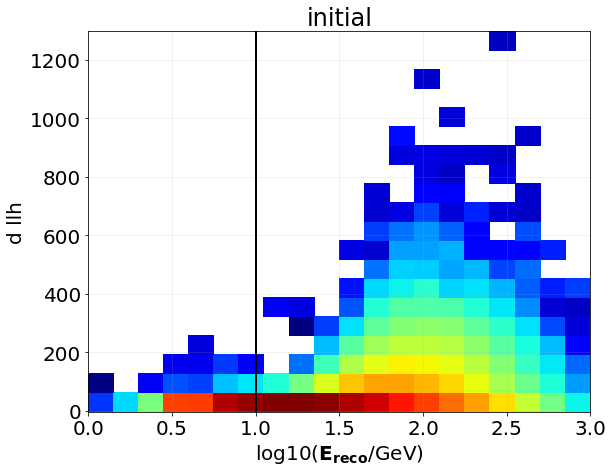

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


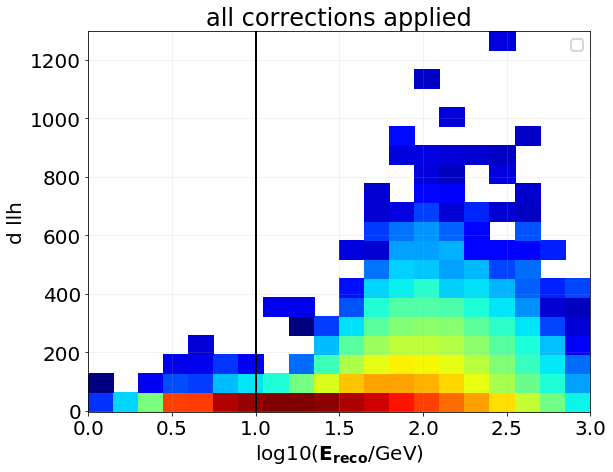

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log10


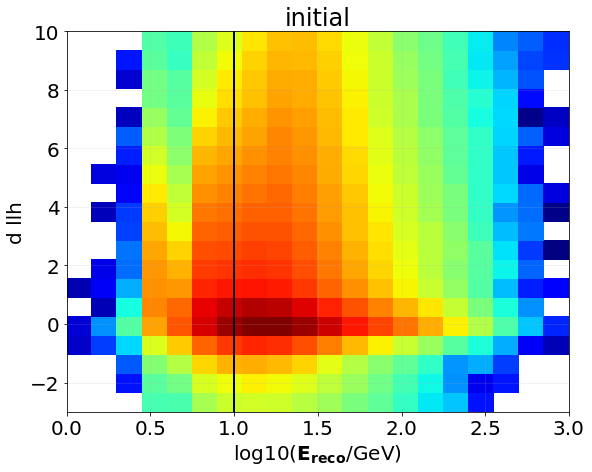

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10
No handles with labels found to put in legend.


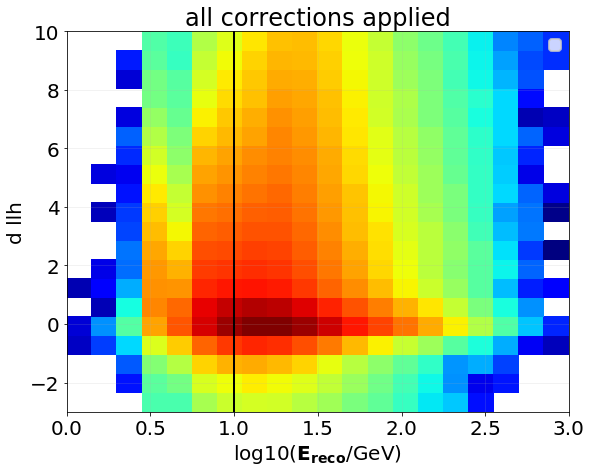

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


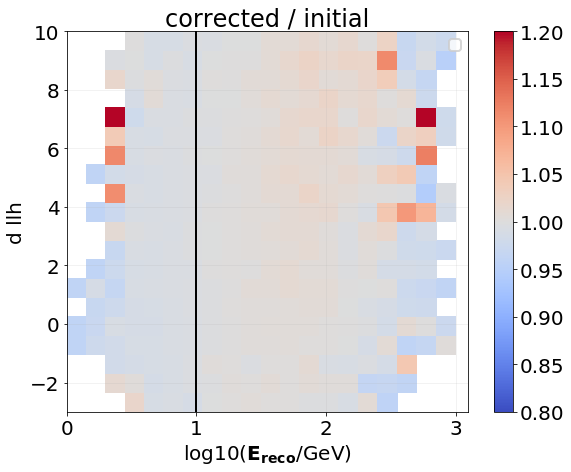

0

In [151]:
plot_y_vs_reco_en(#ind=dis,
                  ind_all=np.arange(len(nu['energy'])),
                  corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                  title='all corrections applied')

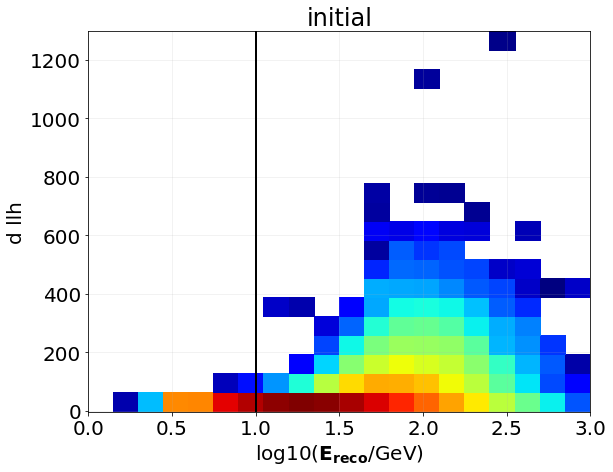

No handles with labels found to put in legend.


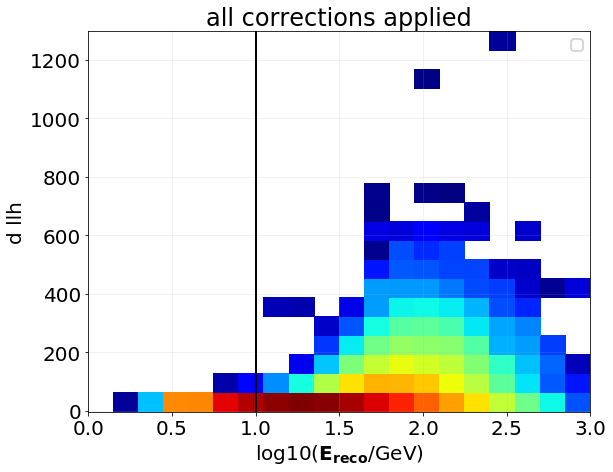

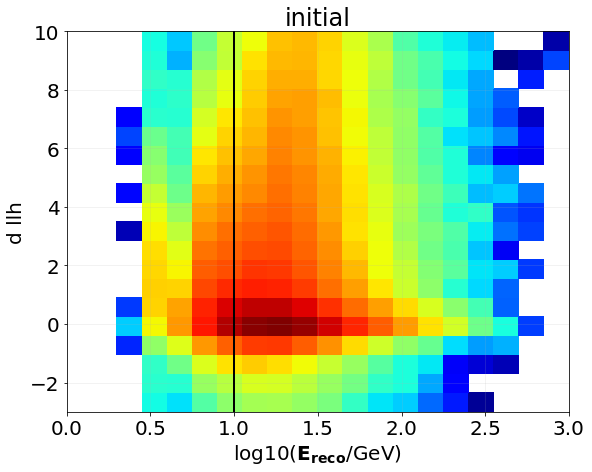

No handles with labels found to put in legend.


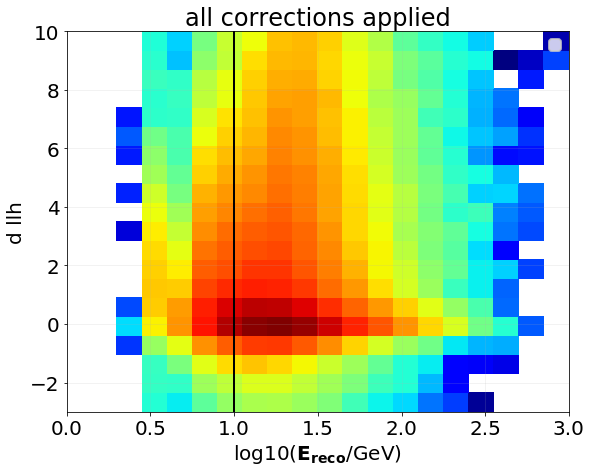

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


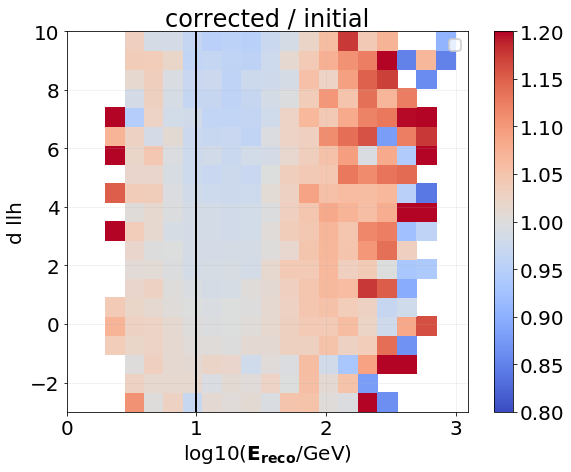

0

In [153]:
plot_y_vs_reco_en(#ind=dis,
                  ind_all=CCdisNuBar,
                  corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                  title='all corrections applied')

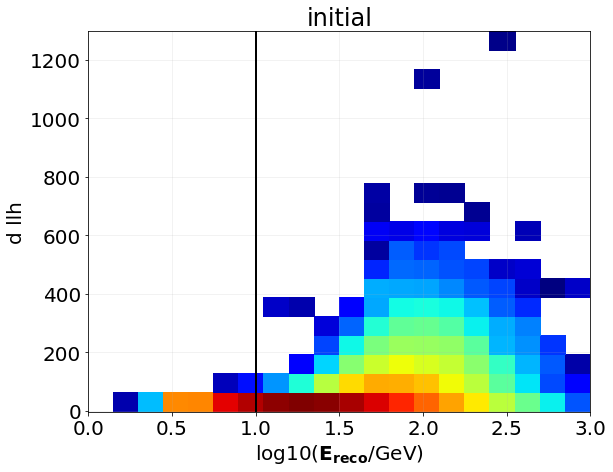

No handles with labels found to put in legend.


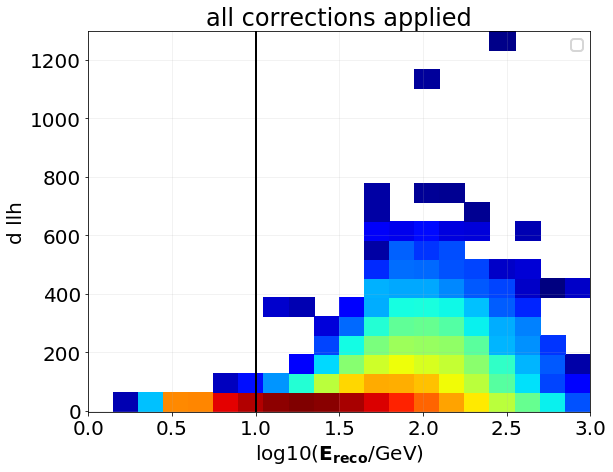

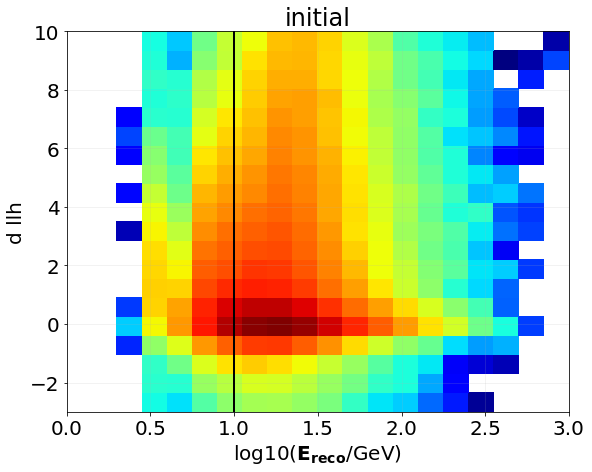

No handles with labels found to put in legend.


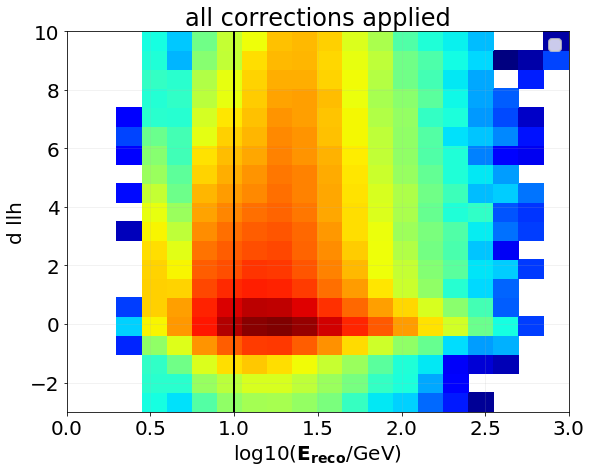

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


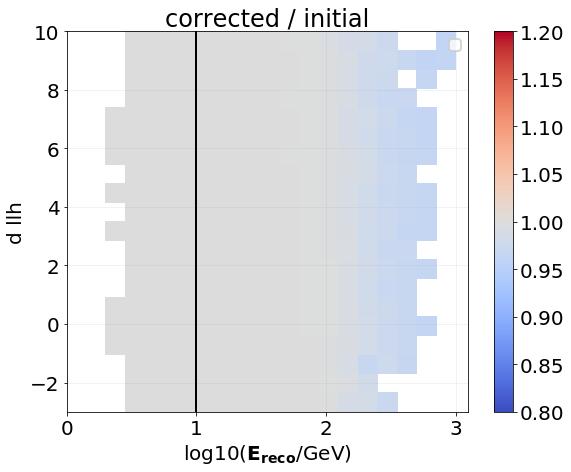

0

In [188]:
plot_y_vs_reco_en(#ind=dis,
                  ind_all=CCdisNuBar,
                  corr={'CCnu':True, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                  title='all corrections applied')

# older plots

In [111]:
def plot_true_en(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(0.,3.1)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)

    h0, be = np.histogram(val[dis], nb, lgE_r, 
                            weights=w0[dis])
    
    hc, be = np.histogram(val[dis], nb, lgE_r, 
                            weights=wcorr_c[dis])
    
    ########
    
    n = np.sum(hc)/np.sum(h0)
    wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(val, nb, lgE_r, 
                            weights=w0)
    hc, be = np.histogram(val, nb, lgE_r, 
                            weights=wcorr_c)
    
    ########
    
#     hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    plt.grid(alpha=0.2)
    ax.axvline(1.68, c='k')
    plt.legend(fontsize=15)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,3.1)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_xlabel(r'$\mathrm{log10({\bf E_{true}} / GeV)}$')
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')

    # sigma0, _ = np.histogram(val, nb, lgE_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')

    plt.grid(alpha=0.2)
    ax2.axvline(1.68, c='k')
    
    save_name = title.replace(' ', '_') + '_true_E'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

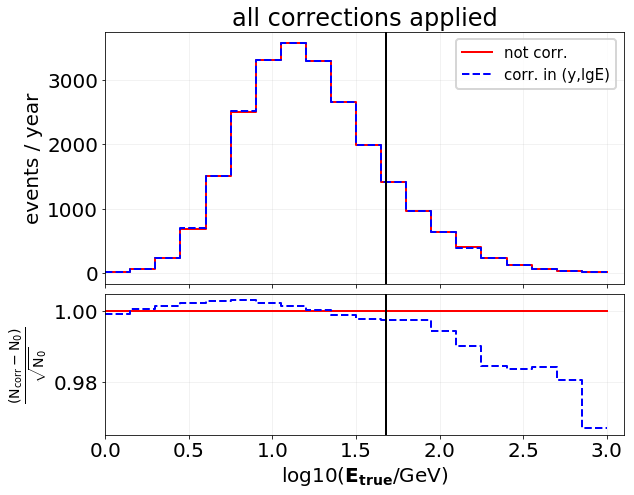

0

In [112]:
plot_true_en(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied')

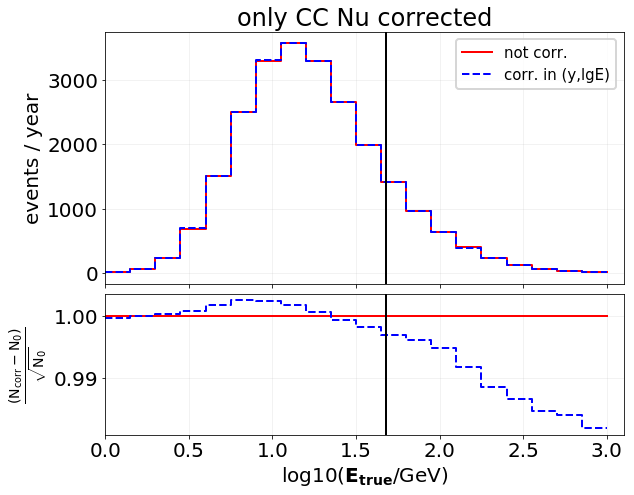

0

In [113]:
plot_true_en(corr={'CCnu':True, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}, 
                title='only CC Nu corrected')

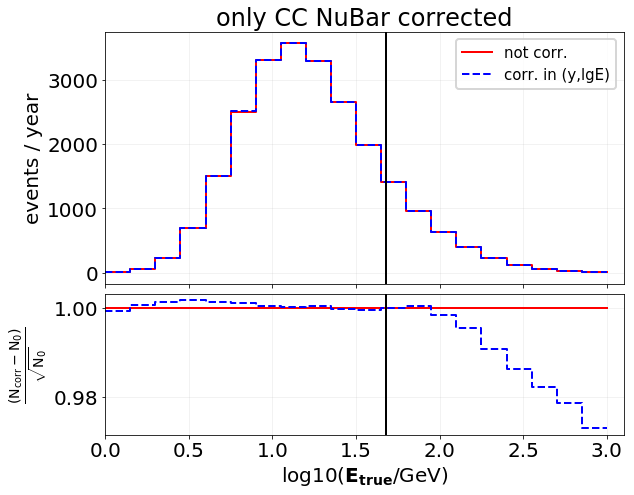

0

In [114]:
plot_true_en(corr={'CCnu':False, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='only CC NuBar corrected')

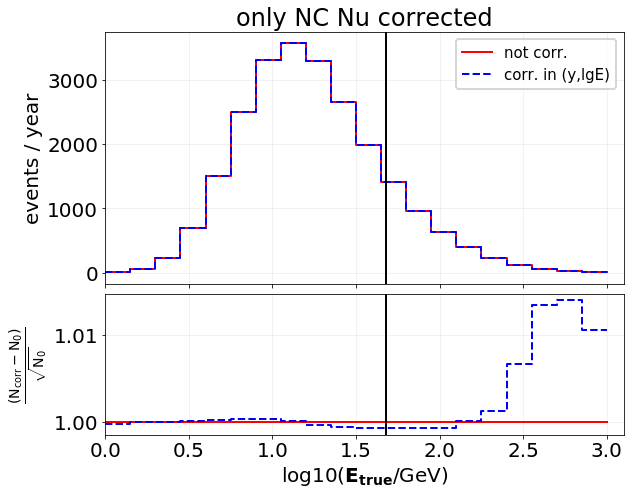

0

In [115]:
plot_true_en(corr={'CCnu':False, 'CCnubar':False, 'NCnu':True, 'NCnubar':False}, 
                title='only NC Nu corrected')

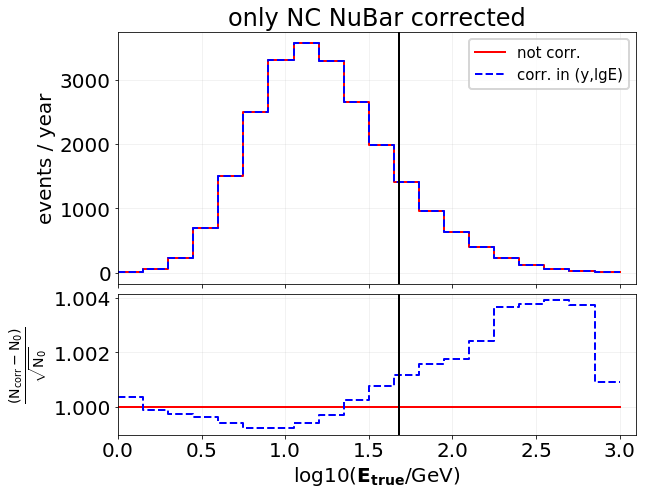

0

In [116]:
plot_true_en(corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':True}, 
                title='only NC NuBar corrected')

In [163]:
def plot_reco_en(plot_val = np.log10(nu['reco_energy']),
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(0.,3.1)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)
    
    h0, be = np.histogram(plot_val[dis], nb, lgE_r, 
                            weights=w0[dis])
    
    hc, be = np.histogram(plot_val[dis], nb, lgE_r, 
                            weights=wcorr_c[dis])

    ########
    
    n = np.sum(hc)/np.sum(h0)
    wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(plot_val, nb, lgE_r, 
                            weights=w0)
    hc, be = np.histogram(plot_val, nb, lgE_r, 
                            weights=wcorr_c)
    
    ########
    
#     print (np.sum(h0))
#     hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    bc = be[:-1] + (be[1]-be[0])/2.

    plt.grid(alpha=0.2)
    ax.axvline(1.68, c='k')
    plt.legend(fontsize=15)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,3.1)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
    ax2.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')

    # sigma0, _ = np.histogram(val, nb, lgE_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    plt.grid(alpha=0.2)
    ax2.axvline(1.68, c='k')
    
    save_name = title.replace(' ', '_') + '_reco_E'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [164]:
def plot_reco_en_ind(iloc=np.arange(len(nu['reco_energy'])),
                plot_val = np.log10(nu['reco_energy']),
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)
    
    

    ax.set_xlim(0.,3.1)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)
    
    h0, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=w0[iloc])
    
    hc, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=wcorr_c[iloc])

    ########
    
    n = np.sum(hc)/np.sum(h0)
    wcorr_c[iloc] = wcorr_c[iloc]/n
    
    h0, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=w0[iloc])
    hc, be = np.histogram(plot_val[iloc], nb, lgE_r, 
                            weights=wcorr_c[iloc])
    
    ########
    
#     print (np.sum(h0))
#     hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    bc = be[:-1] + (be[1]-be[0])/2.

    plt.grid(alpha=0.2)
    ax.axvline(1.68, c='k')
    plt.legend(fontsize=15)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,3.1)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
    ax2.set_xlabel(r'$\mathrm{log10({\bf E_{reco}} / GeV)}$')

    # sigma0, _ = np.histogram(val, nb, lgE_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    plt.grid(alpha=0.2)
    ax2.axvline(1.68, c='k')
    
    save_name = title.replace(' ', '_') + '_reco_E'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

/home/mliubar/myjupyter_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


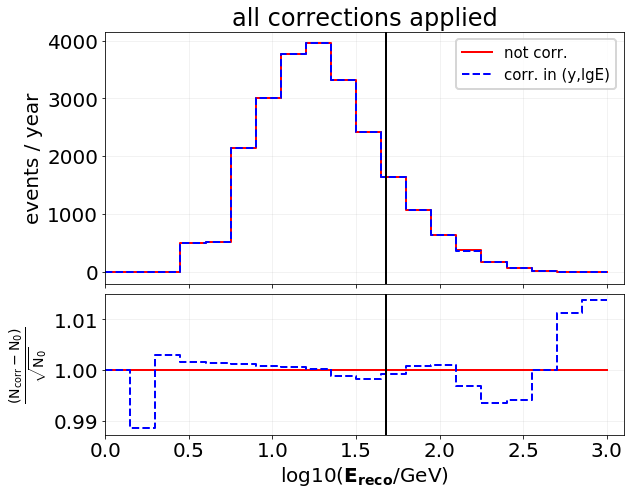

0

In [118]:
plot_reco_en(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied')

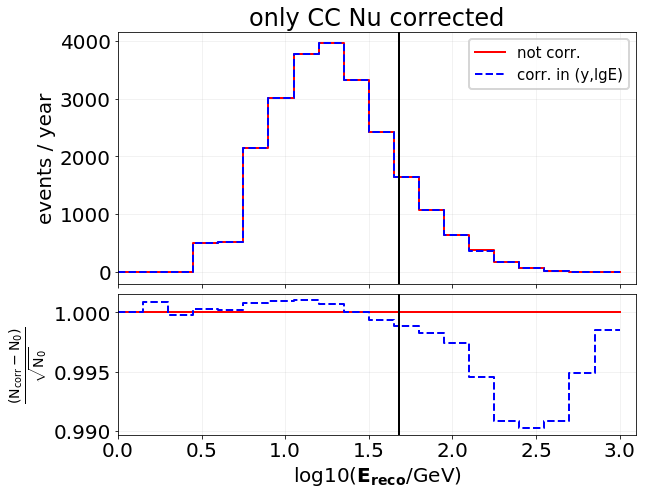

0

In [119]:
plot_reco_en(corr={'CCnu':True, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}, 
                title='only CC Nu corrected')

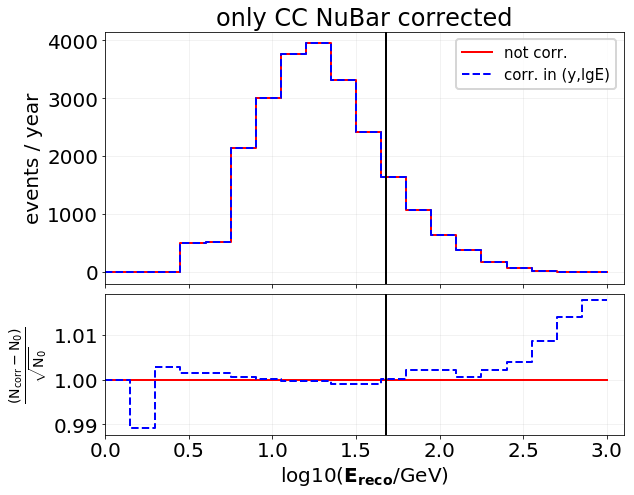

0

In [120]:
plot_reco_en(corr={'CCnu':False, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='only CC NuBar corrected')

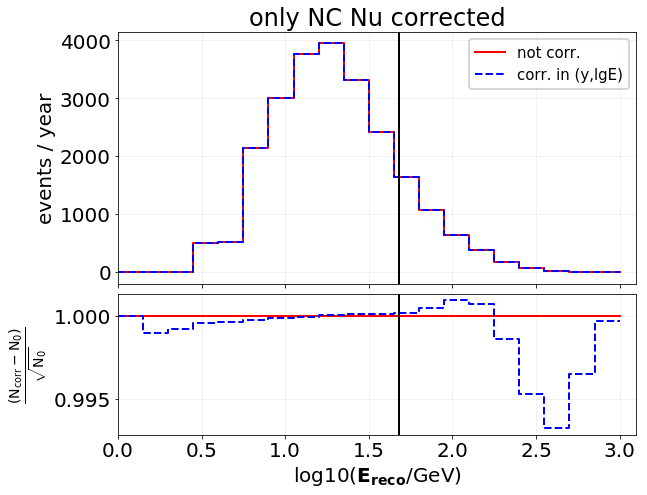

0

In [121]:
plot_reco_en(corr={'CCnu':False, 'CCnubar':False, 'NCnu':True, 'NCnubar':False}, 
                title='only NC Nu corrected')

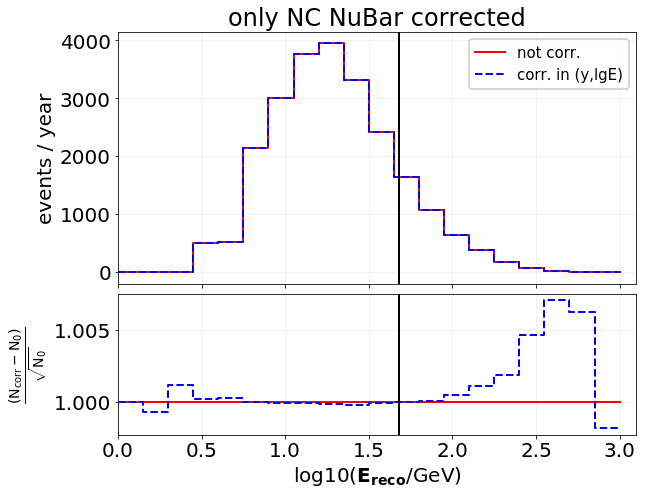

0

In [122]:
plot_reco_en(corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':True}, 
                title='only NC NuBar corrected')

In [123]:
zen_r = [0.,180.]

In [130]:
def plot_reco_zen(plot_val = (nu['reco_zenith']*180/np.pi),
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(0.,180.)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)

#     h0, be = np.histogram(plot_val[dis], nb, zen_r, 
#                             weights=w0[dis])
    
#     hc, be = np.histogram(plot_val[dis], nb, zen_r, 
#                             weights=wcorr_c[dis])
    
#     ########
    
#     n = np.sum(hc)/np.sum(h0)
#     wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(plot_val, nb, zen_r, 
                            weights=w0)
    hc, be = np.histogram(plot_val, nb, zen_r, 
                            weights=wcorr_c)
    
    ########
    
#     print (np.sum(h0))
    hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    plt.grid(alpha=0.2)
    plt.legend(fontsize=15, loc=2)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,180.)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
    ax2.set_xlabel('reco zenith, deg')

    # sigma0, _ = np.histogram(val, nb, zen_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    plt.grid(alpha=0.2)
    
    save_name = title.replace(' ', '_') + '_reco_zen'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

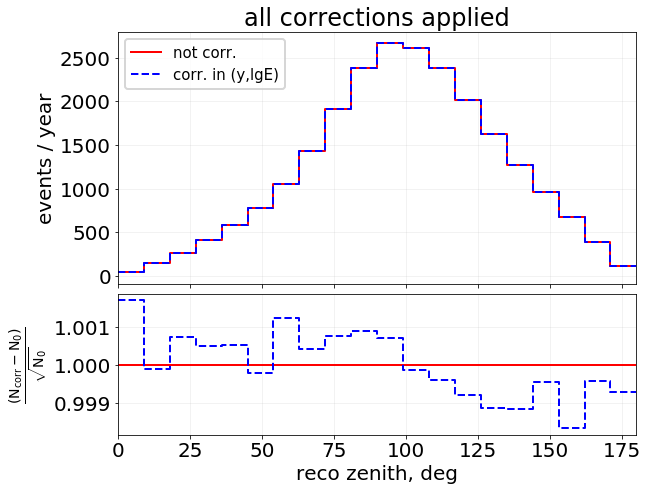

0

In [131]:
plot_reco_zen(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied')

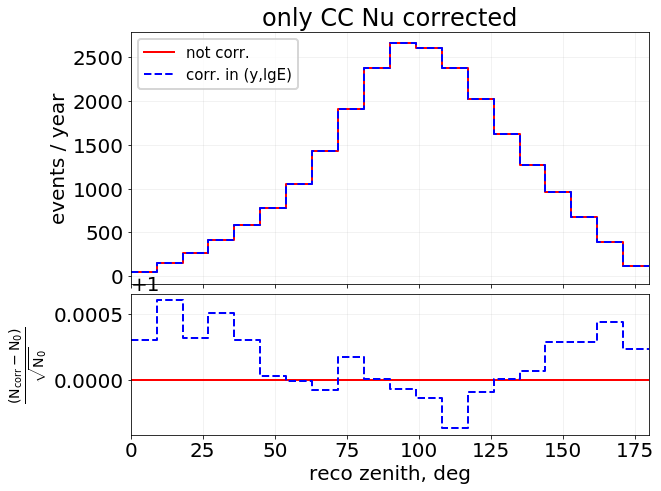

0

In [132]:
plot_reco_zen(corr={'CCnu':True, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}, 
                title='only CC Nu corrected')

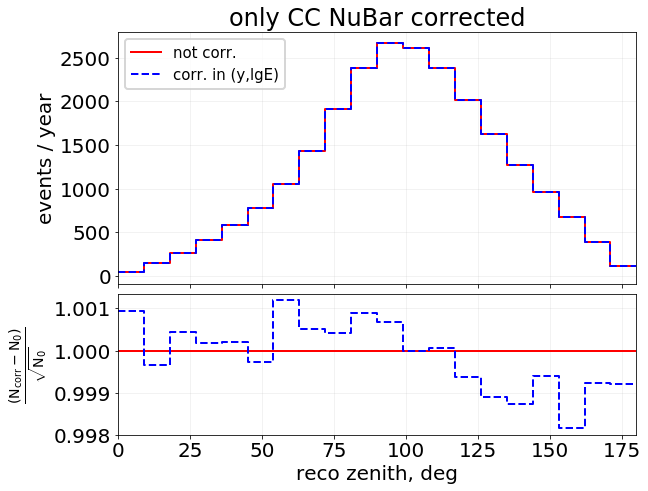

0

In [133]:
plot_reco_zen(corr={'CCnu':False, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='only CC NuBar corrected')

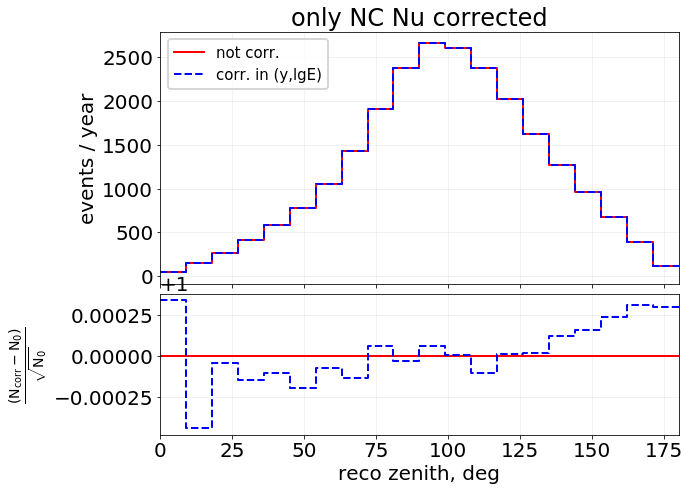

0

In [134]:
plot_reco_zen(corr={'CCnu':False, 'CCnubar':False, 'NCnu':True, 'NCnubar':False}, 
                title='only NC Nu corrected')

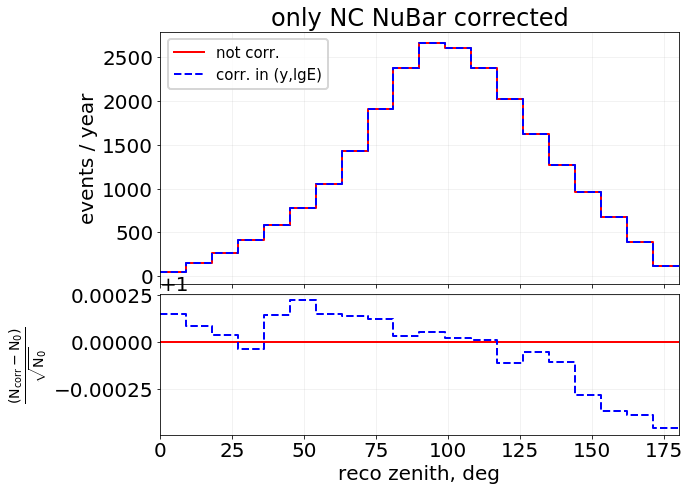

0

In [135]:
plot_reco_zen(corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':True}, 
                title='only NC NuBar corrected')

In [130]:
def plot_reco_zen(iloc=
                plot_val = (nu['reco_zenith']*180/np.pi),
                corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(0.,180.)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)

#     h0, be = np.histogram(plot_val[dis], nb, zen_r, 
#                             weights=w0[dis])
    
#     hc, be = np.histogram(plot_val[dis], nb, zen_r, 
#                             weights=wcorr_c[dis])
    
#     ########
    
#     n = np.sum(hc)/np.sum(h0)
#     wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(plot_val, nb, zen_r, 
                            weights=w0)
    hc, be = np.histogram(plot_val, nb, zen_r, 
                            weights=wcorr_c)
    
    ########
    
#     print (np.sum(h0))
    hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    plt.grid(alpha=0.2)
    plt.legend(fontsize=15, loc=2)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(0.,180.)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
    ax2.set_xlabel('reco zenith, deg')

    # sigma0, _ = np.histogram(val, nb, zen_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    plt.grid(alpha=0.2)
    
    save_name = title.replace(' ', '_') + '_reco_zen'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

In [136]:
dllh_r = [-3., 10.]
# dllh_r_sum = [-3., max(nu['delta_llh'])]
dllh_r_sum = [min(nu['delta_llh']), max(nu['delta_llh'])]

In [137]:
def plot_reco_dllh(plot_val = nu['delta_llh'],
                 corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                 title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(dllh_r)
    # ax.set_ylim(y_r)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)

    sumh0, _ = np.histogram(plot_val, dllh_r_sum, 
                            weights=w0)
    sumhc, _ = np.histogram(plot_val, dllh_r_sum, 
                            weights=wcorr_c)
    ########
    
#     n = sumhc/sumh0
#     wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(plot_val, nb, dllh_r, 
                            weights=w0)
    hc, be = np.histogram(plot_val, nb, dllh_r, 
                            weights=wcorr_c)
    
    ########
    
#     print (sumh0, sumhc)
    hc = hc/sumhc*sumh0
#     hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')

    plt.grid(alpha=0.2)
    ax.axvline(2., c='k', linestyle='-')
    plt.legend(fontsize=15, loc=1)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(dllh_r)
#     ax2.set_ylim(-1.2, 1.2)
#     ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
    ax2.set_xlabel(r'$\mathrm{\Delta LLH}$')
#     ax2.set_ylabel('(corr. -\n not corr.)')

    # sigma0, _ = np.histogram(val, nb, dllh_r)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

#     ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
#     ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.step(be, np.concatenate(([1.],(h0/h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc/h0)[0]],(hc/h0))), color='b', linestyle='--')
    
    ax2.axvline(2., c='k', linestyle='-')
    plt.grid(alpha=0.2)
    
    save_name = title.replace(' ', '_') + '_reco_dllh'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

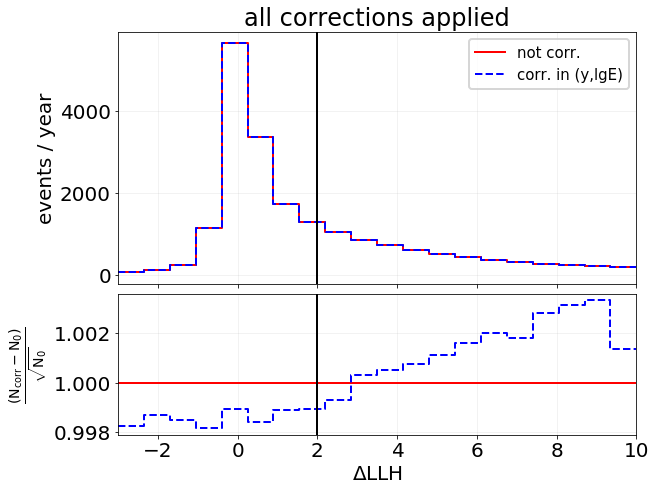

0

In [138]:
plot_reco_dllh(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied')

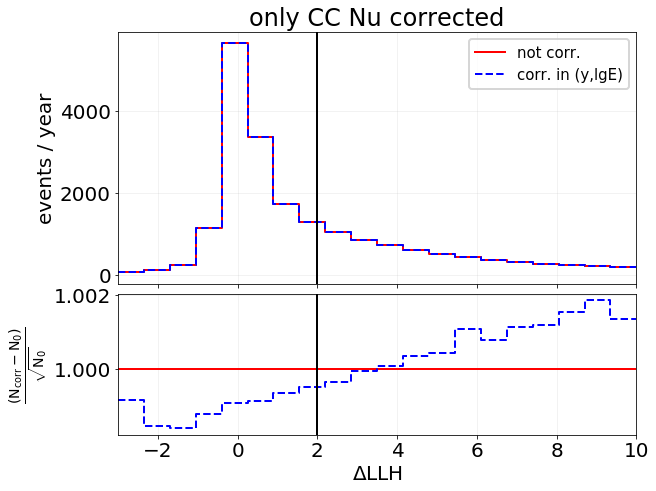

0

In [139]:
plot_reco_dllh(corr={'CCnu':True, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}, 
                title='only CC Nu corrected')

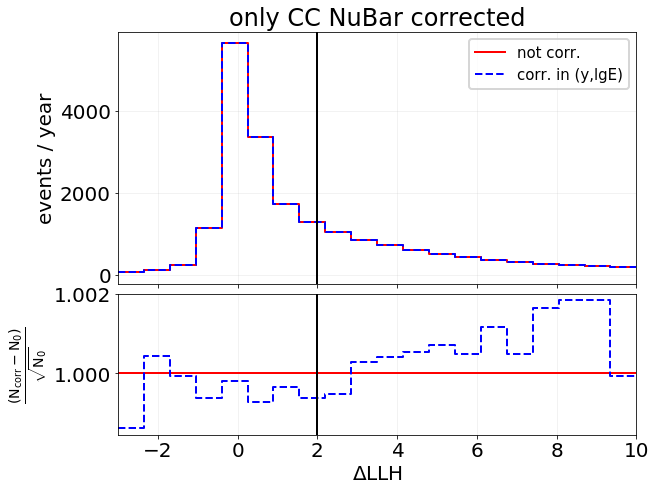

0

In [140]:
plot_reco_dllh(corr={'CCnu':False, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='only CC NuBar corrected')

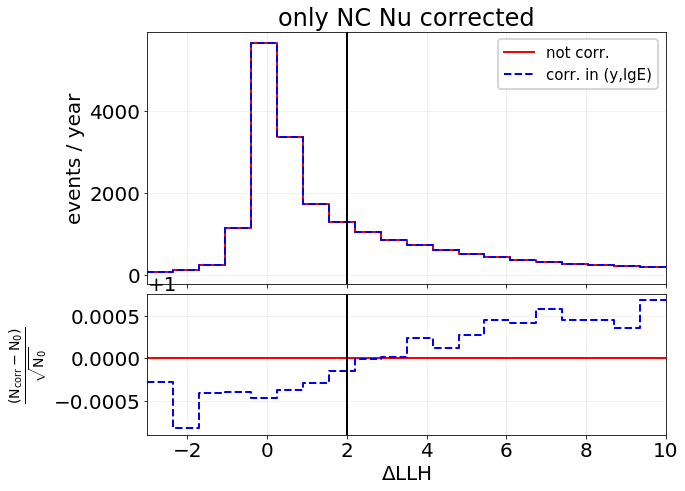

0

In [141]:
plot_reco_dllh(corr={'CCnu':False, 'CCnubar':False, 'NCnu':True, 'NCnubar':False}, 
                title='only NC Nu corrected')

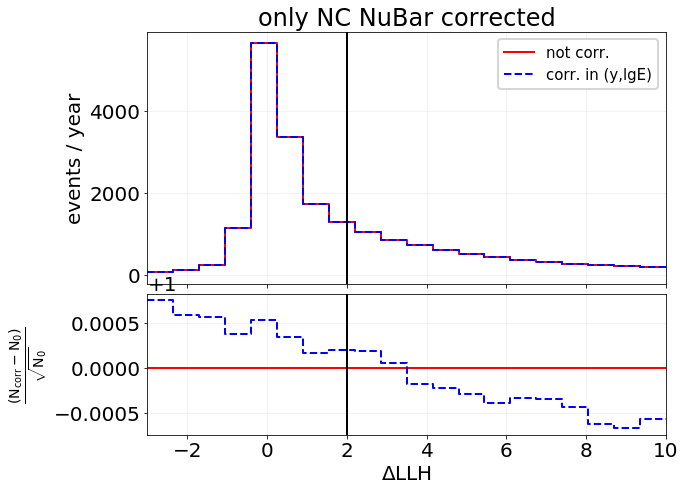

0

In [142]:
plot_reco_dllh(corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':True}, 
                title='only NC NuBar corrected')

In [56]:
def plot_reco_dllh2(plot_val = nu['delta_llh'],
                 corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                 title='all corrections applied'):
    fig = plt.figure(1, figsize=(9, 7))
    ax = plt.axes(rect1)

    ax.set_xlim(dllh_r)
    ax.set_ylim(0.,14500.)
    ax.set_title(title)
    ax.set_ylabel('events / year')
    plt.xticks(visible=False)
    
    bins = np.array([-3.,2., max(nu['delta_llh'])])

    w0, m  = get_w(nyears=1.)
    wcorr_c, _ = get_w(nyears=1., 
                  corr=corr)

    
    h0, be = np.histogram(plot_val, bins, 
                            weights=w0)
    
    hc, be = np.histogram(plot_val, bins, 
                            weights=wcorr_c)
    
    ########
    
#     n = np.sum(hc)/np.sum(h0)
#     wcorr_c[dis] = wcorr_c[dis]/n
    
    h0, be = np.histogram(plot_val, bins, 
                            weights=w0)
    
    hc, be = np.histogram(plot_val, bins, 
                            weights=wcorr_c)
    ########
    
#     print (np.sum(h0))
    hc = hc/np.sum(hc)*np.sum(h0)
    
    ax.step(be, np.concatenate(([h0[0]],h0)), color='r', linestyle='-',
            label='not corr.')    
    ax.step(be, np.concatenate(([hc[0]],hc)), color='b', linestyle='--',
            label='corr. in (y,lgE)')


    bc = be[:-1] + (be[1]-be[0])/2.

    ct0 = h0[0]/h0[1]
    ctc = hc[0]/hc[1]
    
    sig_ct0 = ct0*np.sqrt(1./h0[0]+1./h0[1])
    sig_ctc = ctc*np.sqrt(1./hc[0]+1./hc[1])
    
    plt.text(-2.5, 8000., ('casc / tr ='), color='k')
    plt.text(-2.5, 6800., ('{:.2f}'.format(ct0)+r'$\pm${:.2f}'.format(sig_ct0)), color='red')
    plt.text(-2.5, 5600., ('{:.2f}'.format(ctc)+r'$\pm${:.2f}'.format(sig_ctc)), color='b')
    
    plt.grid(alpha=0.2)
    ax.axvline(2., c='k', linestyle='-')
    plt.legend(fontsize=15, loc=4)
    
    ax2 = plt.axes(rect2)

    ax2.set_xlim(dllh_r)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_yticks([-1., 0., 1.])
    ax2.set_ylabel(r'$\mathrm{\frac{(N_{corr} - N_0)}{\sqrt{N_0}}}$')
#     ax2.set_ylabel('(corr. -\n not corr.)\n/sigma')
    ax2.set_xlabel(r'$\mathrm{\Delta LLH}$')

    # sigma0, _ = np.histogram(val, bins)
    # sigma0 = np.sqrt(sigma0)*w0

    sigma0 = np.sqrt(h0)

    ax2.step(be, np.concatenate(([0.],(h0-h0))), color='r', linestyle='-')
    ax2.step(be, np.concatenate(([(hc-h0)[0]/sigma0[0]],(hc-h0)/sigma0)), color='b', linestyle='--')
    
    ax2.axvline(2., c='k', linestyle='-')
    plt.grid(alpha=0.2)
    
    save_name = title.replace(' ', '_') + '_reco_dllh_ratio'
    plt.savefig(save_pth+save_name+'.png', dpi='figure')
    plt.savefig(save_pth+save_name+'.pdf', dpi='figure')
    
    plt.show()
    
    return 0

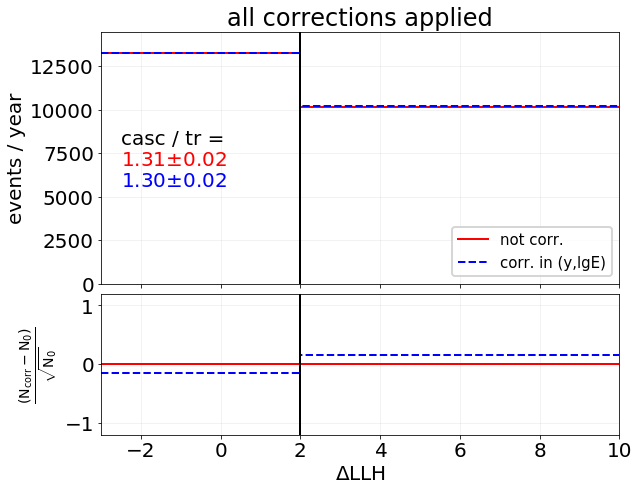

0

In [57]:
plot_reco_dllh2(corr={'CCnu':True, 'CCnubar':True, 'NCnu':True, 'NCnubar':True}, 
                title='all corrections applied')

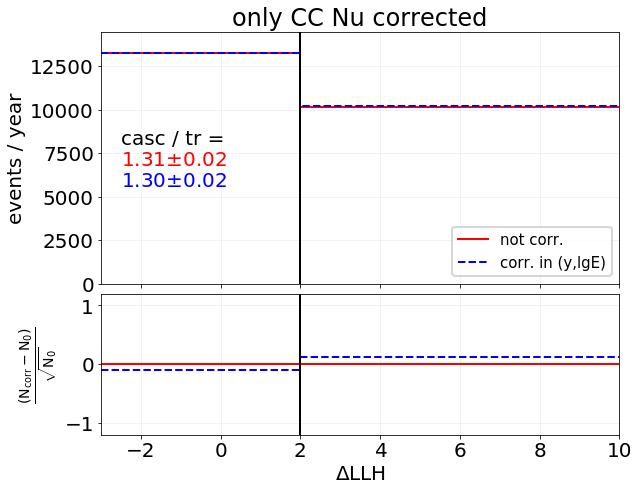

0

In [58]:
plot_reco_dllh2(corr={'CCnu':True, 'CCnubar':False, 'NCnu':False, 'NCnubar':False}, 
                title='only CC Nu corrected')

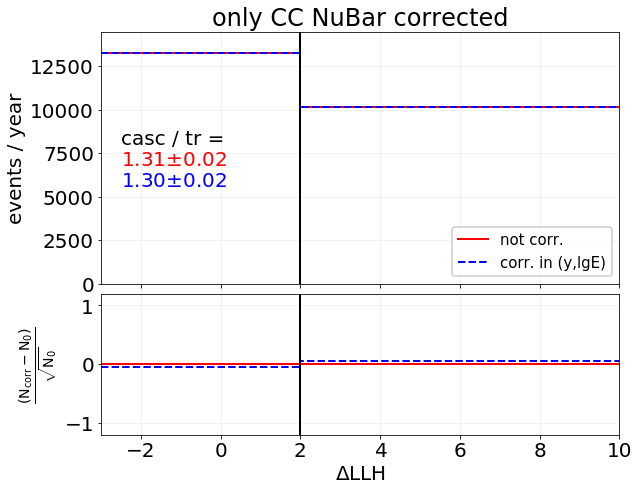

0

In [59]:
plot_reco_dllh2(corr={'CCnu':False, 'CCnubar':True, 'NCnu':False, 'NCnubar':False}, 
                title='only CC NuBar corrected')

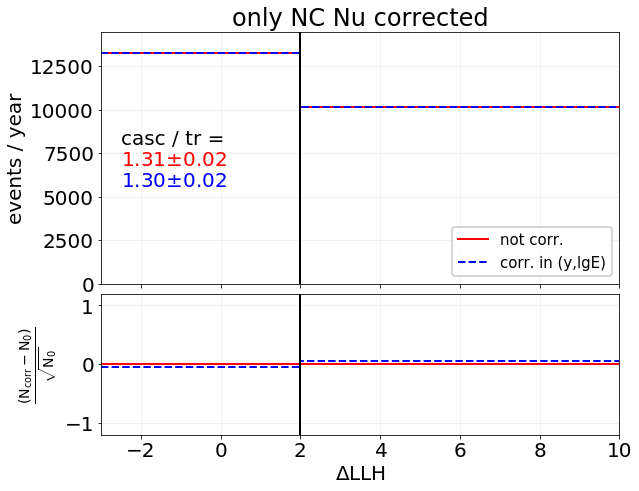

0

In [60]:
plot_reco_dllh2(corr={'CCnu':False, 'CCnubar':False, 'NCnu':True, 'NCnubar':False}, 
                title='only NC Nu corrected')

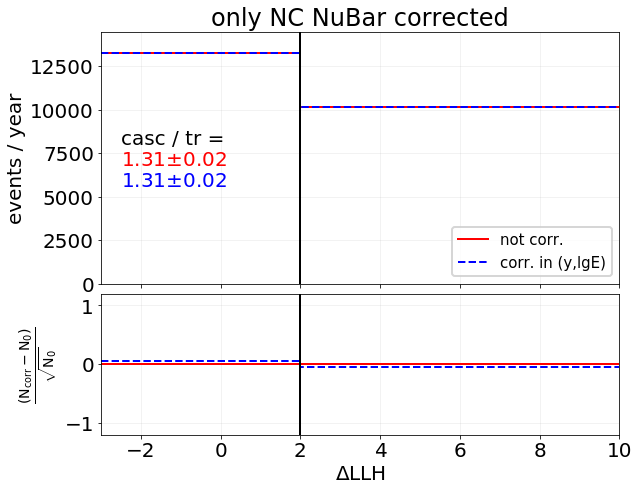

0

In [61]:
plot_reco_dllh2(corr={'CCnu':False, 'CCnubar':False, 'NCnu':False, 'NCnubar':True}, 
                title='only NC NuBar corrected')